In [63]:
import requests
import pandas as pd 
import json
import config
import math

%matplotlib inline

In [24]:
# The url for BLS API v2
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

# API key in config.py which contains: bls_key = 'key'
key = '?registrationkey={}'.format(config.bls_key)

headers = {'Content-type': 'application/json'}

series_dict = {'LNS12300060': 'EPOP'}

df = pd.DataFrame()  # blank pandas dataframe to be filled later

In [25]:
# Include the start and end year here
date_range = (1994, 2017)

# Divide the date range into BLS-API-friendly length requests
req_no = int(math.ceil((date_range[1] - date_range[0]) / 10.0))
dates = []
for i in range(0,req_no):
    d1 = str(date_range[0]+i*10)
    d2 = str(date_range[0]+i*10+9)
    dates.append((d1,d2))
dates[-1] = (dates[-1][0], str(date_range[1]))

dates

[('1994', '2003'), ('2004', '2013'), ('2014', '2017')]

In [26]:
for start, end in dates:
        
    # The data sent in the post request now includes a start and end year
    data = json.dumps({"seriesid":series_dict.keys(), "startyear":start, "endyear":end})
    p = requests.post('{}{}'.format(url, key), headers=headers, data=data).json()
    d = {} # New dictionary to be filled with data
    for series in p['Results']['series']:
        s = series['seriesID']  # Shorten name to 's'
        
        # Add dictionary entry with series and reverse series order
        d[s] = pd.DataFrame(series['data']).iloc[::-1]
        if len(series['data']) > 0:  # This if/else is to allow for series of different lengths
            
            # Convert BLS API dates to readable format (YYYY-MM-DD)
            d[s]['date'] = pd.to_datetime(d[s]['period'] + ' ' + d[s]['year'])
            
            # Keep only date and series values
            d[s] = d[s].set_index('date')['value'].astype(float)
            
            # Rename and identify values as floating point numbers
            d[s] = d[s].rename(series_dict[s])
        else:  # If blank, leave as a blank pandas series
            d[s]['date'] = d[s]['value'] = pd.Series()
            d[s] = d[s]['value'].rename(series_dict[s])
            
    # Combine the dataframes for each range of years into one by appending        
    df = df.append(pd.concat([d[k] for k in series_dict.keys()], axis=1))

In [31]:
df.resample('3M', closed='left').mean().to_csv('epop.csv')

In [42]:
epop = df.resample('3M', closed='left').mean()[:-1]
eci = pd.read_csv('ECI.csv').set_index('date')

In [58]:
df2 = epop.join(eci)
df2['UPOP'] = [100 - df2['EPOP'].values][0]

In [69]:
df2.tail()

,EPOP,ECI,UPOP
date,,,
2016-06-30,77.766667,2.3,22.233333
2016-09-30,77.933333,2.3,22.066667
2016-12-31,78.200000,2.2,21.800000
2017-03-31,78.333333,2.4,21.666667
2017-06-30,78.500000,2.4,21.500000


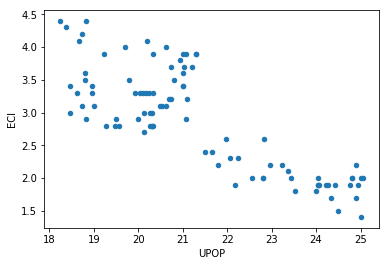

In [64]:
df2[['ECI', 'UPOP']].plot(kind='scatter', x='UPOP', y='ECI')

In [67]:
import statsmodels.api as sm

/home/domestic_ra/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [68]:
X = df2['UPOP'] ## X usually means our input variables (or independent variables)
y = df2['ECI'] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ECI   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     177.3
Date:                Thu, 17 Aug 2017   Prob (F-statistic):           3.55e-23
Time:                        15:11:55   Log-Likelihood:                -59.317
No. Observations:                  94   AIC:                             122.6
Df Residuals:                      92   BIC:                             127.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5578      0.504     18.982      0.000       8.558      10.558
UPOP          -0.3128      0.023    -13.315      0.000      -0.359      -0.266
==============================================================================
Omnibus:                        5.720   Durbin-Watson:                   0.268
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                5.027
Skew:                           0.483   Prob(JB):                       0.0810
Kurtosis:                       2.408   Cond. No.                         228.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""